In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd

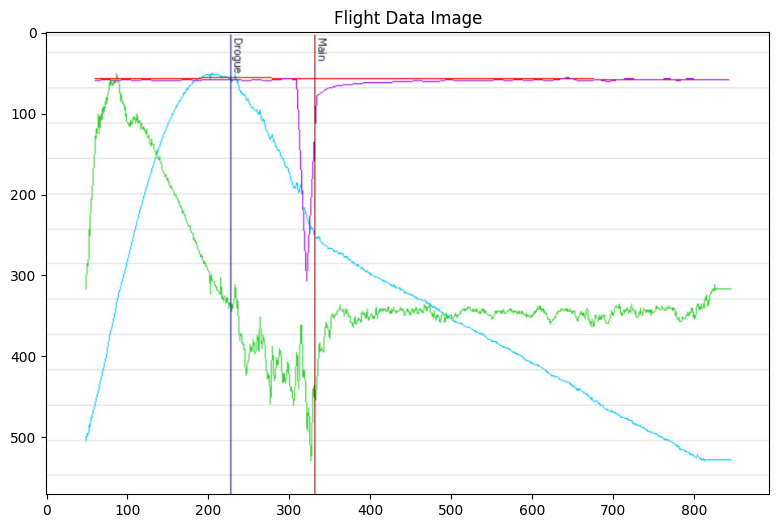

In [2]:
# Load the uploaded flight data image
image_path = "croped.jpg"
img = Image.open(image_path)

# Display the image for manual inspection and alignment
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.title("Flight Data Image")
plt.axis("on")
plt.show()

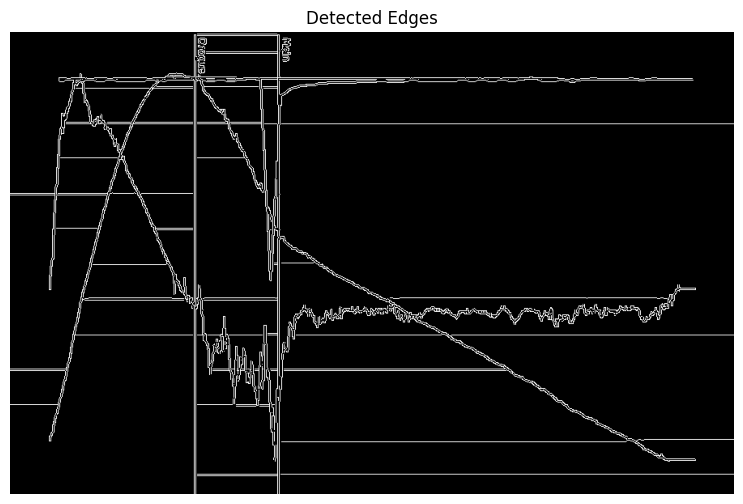

In [3]:
# Convert image to OpenCV format and grayscale
img_cv = np.array(img)
gray = cv2.cvtColor(img_cv, cv2.COLOR_RGB2GRAY)

# Apply edge detection
edges = cv2.Canny(gray, threshold1=50, threshold2=150)

# Display edges to help identify curves
plt.figure(figsize=(12, 6))
plt.imshow(edges, cmap='gray')
plt.title("Detected Edges")
plt.axis("off")
plt.show()

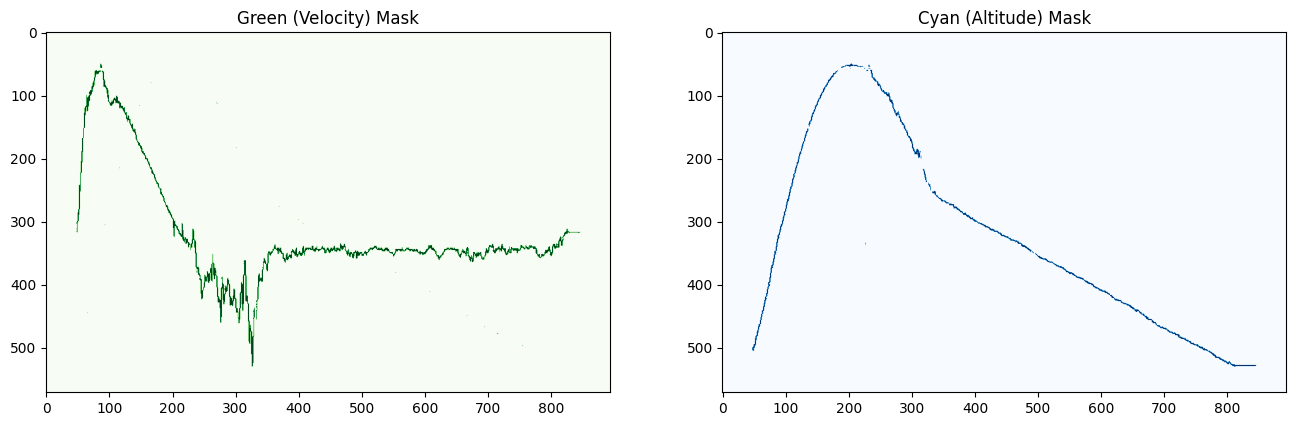

In [4]:
# Convert image to HSV to isolate colors
hsv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2HSV)

# Define color ranges to mask green (velocity) and cyan (altitude)
green_lower = np.array([40, 50, 50])
green_upper = np.array([90, 255, 255])

cyan_lower = np.array([80, 50, 50])
cyan_upper = np.array([100, 255, 255])

# Create masks for green and cyan
mask_green = cv2.inRange(hsv, green_lower, green_upper)
mask_cyan = cv2.inRange(hsv, cyan_lower, cyan_upper)

# Get non-zero pixel coordinates
green_coords = np.column_stack(np.where(mask_green > 0))
cyan_coords = np.column_stack(np.where(mask_cyan > 0))

# Display masked results
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].imshow(mask_green, cmap="Greens")
ax[0].set_title("Green (Velocity) Mask")
ax[1].imshow(mask_cyan, cmap="Blues")
ax[1].set_title("Cyan (Altitude) Mask")
plt.show()

In [5]:
# Función para convertir coordenadas de píxel a valores reales
def pixel_to_data(coords, x_pix_min, x_pix_max, x_val_min, x_val_max, 
                         y_pix_min, y_pix_max, y_val_min, y_val_max):
    x_pix = coords[:, 1]
    y_pix = coords[:, 0]
    x_val = ((x_pix - x_pix_min) / (x_pix_max - x_pix_min)) * (x_val_max - x_val_min) + x_val_min
    y_val = ((y_pix - y_pix_min) / (y_pix_max - y_pix_min)) * (y_val_min - y_val_max) + y_val_max
    return np.column_stack((x_val, y_val))

# Coordenadas de píxeles del área del gráfico (estimadas del gráfico original)
x_pix_min, x_pix_max = 50, 850   # eje X: tiempo
y_pix_min, y_pix_max = 30, 520   # eje Y

# Rango de valores del gráfico
t_min, t_max = 0, 65            # tiempo en segundos
alt_min, alt_max = -200, 2200   # altura en metros
vel_min, vel_max = -80, 100     # velocidad en m/s

# Convertir las coordenadas
altitude_data = pixel_to_data(cyan_coords, x_pix_min, x_pix_max, t_min, t_max,
                                            y_pix_min, y_pix_max, alt_min, alt_max)
velocity_data = pixel_to_data(green_coords, x_pix_min, x_pix_max, t_min, t_max,
                                            y_pix_min, y_pix_max, vel_min, vel_max)

Extraer los csv para procesar algunos datos a mano

In [ ]:
df = pd.DataFrame({
    'Time (s)': altitude_data[:, 0],
    'Altitude (m)': altitude_data[:, 1]
})
df.to_csv('altitude_flight_data.csv', index=False)

df = pd.DataFrame({
    'Time (s)': velocity_data[:, 0],
    'Velocity (m/s)': velocity_data[:, 1]
})
df.to_csv('velocity_flight_data.csv', index=False)

## Process data

Los archivos tienen muchos datos inecesarios y si no se eliminan la aceleración no tiene sentido. Los elimine a mano con excel

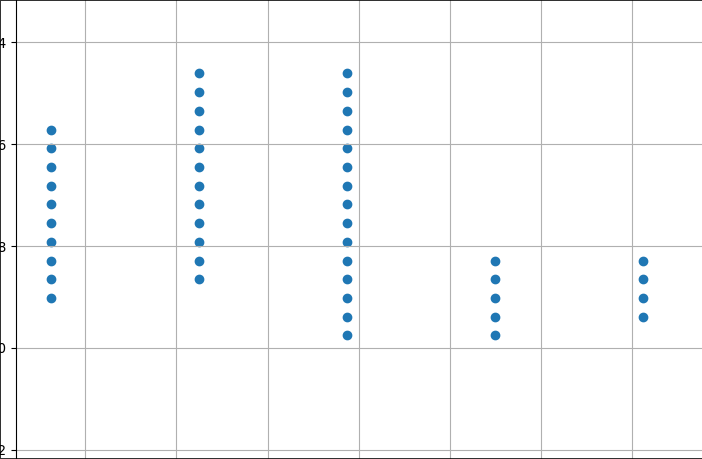

Para mejor aproximacion hay que suavizar la velocidad. Los datos hasta APOGEE tienen menos ruido y son los que me importa analizar así solo tomo ese rango de datos

In [8]:
df = pd.read_csv("apogee.csv")   

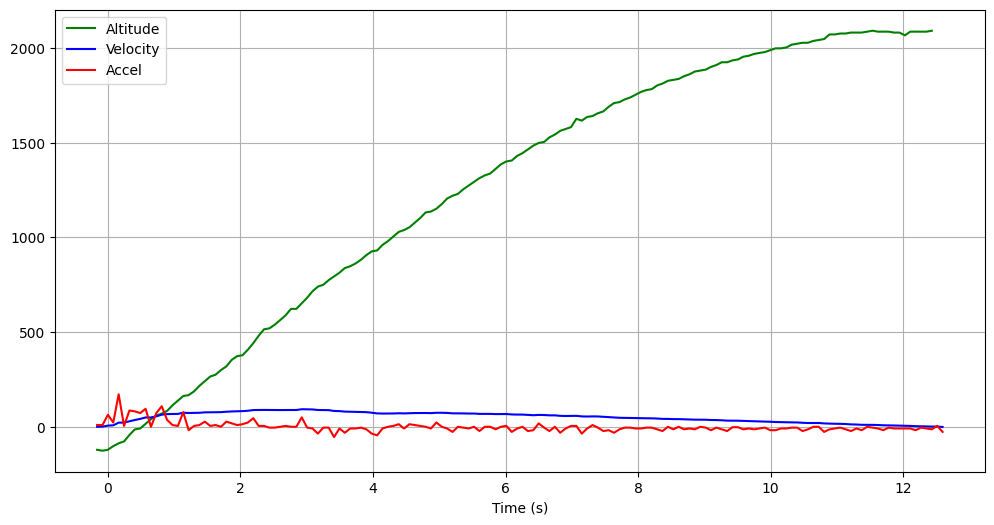

In [9]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['Time (s)'], df['Altitude (m)'], label='Altitude', color='green')
plt.plot(df['Time (s)'], df['Velocity (m/s)'], label='Velocity', color='blue')
plt.plot(df['Time (s)'], df['Acceleration (m/s²)'], label='Accel', color='red')

plt.xlabel('Time (s)')
plt.grid(True)
plt.legend()
plt.show()


In [10]:
from scipy.signal import savgol_filter

In [11]:
altitude = savgol_filter(df['Altitude (m)'], window_length=11, polyorder=3)
velocity = savgol_filter(df['Velocity (m/s)'], window_length=11, polyorder=3)
acceleration = np.gradient(velocity, 0.08125)

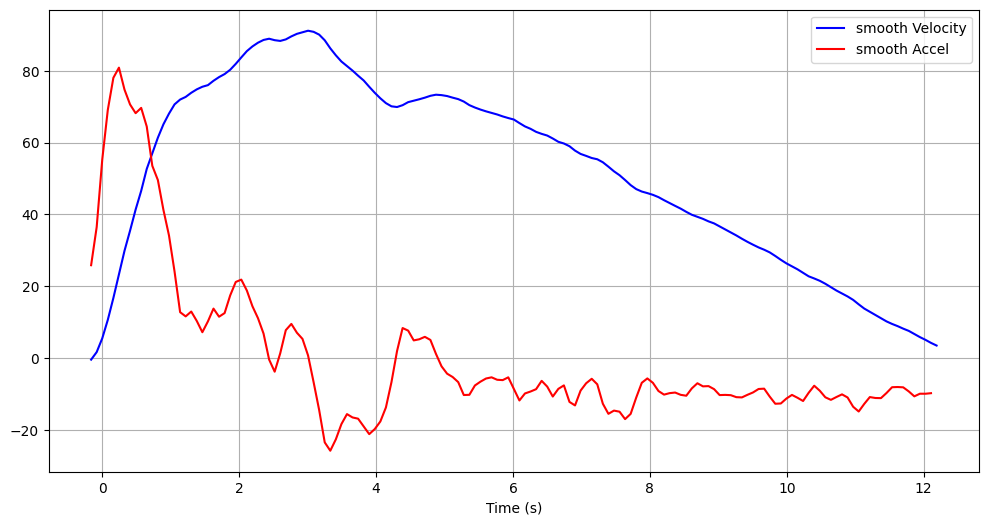

In [13]:
plt.figure(figsize=(12, 6))
# plt.plot(df['Time (s)'], altitude, label='Altitude', color='green')
plt.plot(df['Time (s)'], velocity, label='smooth Velocity', color='blue')
plt.plot(df['Time (s)'], acceleration, label='smooth Accel', color='red')

plt.xlabel('Time (s)')
plt.grid(True)
plt.legend()
plt.show()
